In [ ]:
# %load_ext autoreload
# %autoreload 2

In [1]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [2]:
from __future__ import annotations
import jax
import jax.numpy as jnp
import equinox as eqx
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from jax import vmap
# from graphjax.graph import MorphTree

from typing import Optional, List, Dict, Any, Union, Set, Tuple
from dataclasses import dataclass, field

In [834]:
def swc_to_morph_tree(fname: str, num_lines: Optional[int] = None) -> MorphTree:
    i_id_xyzr_p = jnp.array(np.loadtxt(fname)[:num_lines])
    
    edges = i_id_xyzr_p[:, [0, -1]]
    edges = edges[edges[:, 1] != -1].astype(int)
    
    nodes = i_id_xyzr_p[:, 0].astype(int)
    
    get_node_attrs = lambda id, x, y, z, r: {"id": int(id), "x": x, "y": y, "z": z, "r": r}
    node_attrs = list(map(get_node_attrs, *i_id_xyzr_p[:, 1:-1].T))    
    return MorphTree(nodes, edges, node_attrs)

@dataclass
class MorphTree:
    nodes: jnp.ndarray
    edges: jnp.ndarray
    node_attrs: List[Dict[str, Any]] = None
    edge_attrs: List[Dict[str, Any]] = None
    global_attrs: Dict[str, Any] = field(default_factory=dict)

    def __post_init__(self) -> None:
        if self.node_attrs is None:
            self.node_attrs = [{}]*len(self.nodes)
        if self.edge_attrs is None:
            self.edge_attrs = [{}]*len(self.edges)

    def __repr__(self) -> str:
        n_nodes = len(self.nodes)
        n_edges = len(self.edges)

        node_attrs = list(self.node_attrs[0].keys()) if len(self.node_attrs) > 0 else []
        edge_attrs = list(self.edge_attrs[0].keys()) if len(self.edge_attrs) > 0 else []
        return f"MorphTree(nodes={n_nodes}*{node_attrs}, edges={n_edges}*{edge_attrs})"
    
    def to_nx(self) -> nx.DiGraph:
        G = nx.DiGraph()
        node_map = map(int, self.nodes)
        edge_map = map(lambda x: tuple(map(int, x)), self.edges.T)
        G.add_nodes_from(zip(node_map, self.node_attrs))
        G.add_edges_from(zip(*edge_map, self.edge_attrs))
        return G
    
    @staticmethod
    def from_nx(G: nx.DiGraph) -> MorphTree:
        nodes = jnp.array(list(G.nodes))
        edges = jnp.array(list(G.edges))
        node_attrs = [G.nodes[n] for n in G.nodes]
        edge_attrs = [G.edges[e] for e in G.edges]
        return MorphTree(nodes, edges, node_attrs, edge_attrs)
    
    def to_pandas(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        node_df = pd.DataFrame(self.node_attrs, index=np.array(self.nodes))
        edge_df = pd.DataFrame(self.edge_attrs)
        edge_index = pd.MultiIndex.from_arrays(np.array(self.edges).T)
        edge_df = edge_df.set_index(edge_index)
        return node_df, edge_df
    
    @staticmethod
    def from_pandas(node_df: pd.DataFrame, edge_df: pd.DataFrame) -> MorphTree:
        node_attrs = node_df.to_dict(orient="records")
        edge_attrs = edge_df.to_dict(orient="records")
        edges = edge_df.index.to_numpy()
        nodes = node_df.index.to_numpy()
        return MorphTree(nodes, edges, node_attrs, edge_attrs)
    
    def plot(self, **kwargs: Any) -> None:
        G = self.to_nx()
        pos = {}
        for n, attr in G.nodes(data=True):
            if "x" in attr:  # assume y is also present
                pos[n] = (attr["x"], attr["y"])
        nx.draw(G, pos, with_labels=True, **kwargs)
        plt.show()

    def reindex_nodes(self, new_indices: jnp.ndarray) -> MorphTree:
        def remap(x: int) -> int:
            idx = jnp.argmax(self.nodes == x)
            exists = self.nodes[idx] == x
            return jnp.where(exists, new_indices[idx], x)

        new_nodes = vmap(remap)(self.nodes.ravel()).reshape(self.nodes.shape)
        new_edges = vmap(remap)(self.edges.ravel()).reshape(self.edges.shape)
        return MorphTree(new_nodes, new_edges, self.node_attrs, self.edge_attrs)
    
    def reorder_tree(self, new_order: jnp.ndarray) -> MorphTree:
        # TODO: check this does what I think it does, i.e. change the edge orientation
        # in order of appearance of the nodes in self.nodes.
        new_nodes = self.nodes[new_order]
        new_tree = self.reindex_nodes(new_nodes)

        new_edges = new_tree.edges
        idx_i = jnp.where(new_edges[:,0] == new_tree.nodes[:, None])[0]
        idx_j = jnp.where(new_edges[:,1] == new_tree.nodes[:, None])[0]
        is_descending = ~(idx_i < idx_j)[:, None]
        ascending_edges = jnp.where(is_descending, new_edges[:, ::-1], new_edges)
        return MorphTree(new_nodes, ascending_edges, new_tree.node_attrs, new_tree.edge_attrs)

def list_branches(tree: MorphTree, return_branchpoints: bool = False) -> Union[List[List[int]], Tuple[List[List[int]], Set[int], List[Tuple[int, int]]]]:
    G = tree.to_nx().to_undirected()
    branches: List[List[int]] = []
    branchpoints: Set[int] = set()
    visited: Set[Tuple[int, int]] = set()

    def is_branchpoint(n: int) -> bool:
        is_leaf = G.degree(n) <= 1
        is_branching = G.degree(n) > 2
        if G.degree(n) == 2:
            i,j = G.neighbors(n)
             # trace dir matters here! For segment with node IDs: [1, 1, 2, 2]
             # -> [[1,1], [1,2,2]] 
             # <- [[2,2], [2,1,1]] 
            if is_soma(n):
                return not same_id(n, j)
            else:
                # return not any([same_id(n, i), same_id(n, j)])
                return not same_id(n, j)
        
        return is_leaf or is_branching

    def in_visited(n1: int, n2: int) -> bool:
        return (n1, n2) in visited or (n2, n1) in visited

    def same_id(n1: int, n2: int) -> bool:
        return G.nodes[n1]["id"] == G.nodes[n2]["id"] if "id" in G.nodes[n1] else True

    def is_soma(n: int) -> bool:
        return G.nodes[n]["id"] == 1
    
    def soma_nodes() -> bool:
        return [i for i, n in G.nodes.items() if n["id"] == 1]

    def walk_path(start: int, succ: int) -> List[int]:
        path = [start, succ]
        visited.add((start, succ))
 
        while G.degree(succ) == 2:
            next_node = next(n for n in G.neighbors(succ) if n != path[-2])

            if in_visited(succ, next_node) or is_branchpoint(succ):
                break
            
            path.append(next_node)
            visited.add((succ, next_node))
            succ = next_node

        return path

    leaf = next(n for n in G.nodes if G.degree(n) == 1)
    soma_nodes = soma_nodes()
    for node in nx.dfs_tree(G, leaf):
        if is_soma(node) and len(soma_nodes) == 1:
            branches.append([node])

        elif is_branchpoint(node):
            branchpoints.add(node)
            for succ in G.neighbors(node):
                if not in_visited(node, succ):
                    branches.append(walk_path(node, succ))
    
    if return_branchpoints:
        branchpoint_edges = sum([list(G.edges(n)) for n in branchpoints], [])
        return branches, branchpoints, branchpoint_edges
    return branches

# def compartmentalize(tree: MorphTree, num_comps: int = 1) -> MorphTree:
#     branches = list_branches(tree)
#     nodes_df, _ = tree.to_pandas()
#     nodes_df = nodes_df.astype(float)

#     new_inds = len(branches)*num_comps
#     existing_inds = set(nodes_df.index)
#     proposed_new_inds = set(range(len(branches)*num_comps + len(existing_inds)))
#     new_inds = list(proposed_new_inds.difference(existing_inds))
    
#     branch_nodes: List[np.ndarray] = []
#     branch_edges: List[List[Tuple[int, int]]] = []
#     for i, b in enumerate(branches):
#         branch_node_attrs = nodes_df.loc[b]
#         xyz_i = branch_node_attrs[["x", "y", "z"]]
#         pathlen = ((xyz_i.diff(axis=0).fillna(0)**2).sum(axis=1)**.5)
#         branch_node_attrs["l"] = pathlen.cumsum()
#         v_interp = vmap(jnp.interp, in_axes=(None, None, 1), out_axes=1)

#         branch_len = max(branch_node_attrs["l"])
#         comp_len = branch_len / num_comps
#         comp_locs = jnp.linspace(comp_len/2, branch_len - comp_len/2, num_comps)
        
#         x = jnp.array([0] + list(comp_locs) + [branch_len])
#         xp = jnp.array(branch_node_attrs["l"].values)
#         fp = jnp.array(branch_node_attrs[["x", "y", "z", "r"]].values)

#         tmp_inds = [b[0]] + new_inds[i:i+num_comps] + [b[-1]]
#         types = [0] + [1]*num_comps + [0] # 0: branchpoint, 1: compartment
#         branch_idx = [i]*(num_comps+2)
#         comp_inds_and_type = np.array([tmp_inds, branch_idx, types]).T
#         comp_xyzr = np.array(v_interp(x, xp, fp))
#         comp_xyzr = np.hstack([comp_inds_and_type, comp_xyzr])

#         branch_edges.append([(i,j) for i,j in zip(tmp_inds[:-1], tmp_inds[1:])])
#         branch_nodes.append(comp_xyzr)

#     branch_nodes = jnp.concatenate(branch_nodes)
#     comp_attrs_keys = ["idx", "branch", "type", "x", "y", "z", "r"]
#     comp_df = pd.DataFrame(branch_nodes, columns=comp_attrs_keys)
#     comp_df[["idx", "branch", "type"]] = comp_df[["idx", "branch", "type"]].astype(int)
    
#     # drop duplicated branch nodes
#     comp_df = comp_df.drop_duplicates(subset=["idx"])
#     comp_df = comp_df.set_index("idx")

#     comps = jnp.array(comp_df.index)
#     comp_attrs = comp_df.to_dict(orient="records")
#     comp_edges = jnp.array(sum(branch_edges, []))

#     comp_tree = MorphTree(comps, comp_edges, comp_attrs)
#     comp_tree = comp_tree.reindex_nodes(jnp.arange(len(comps)))
#     return comp_tree

In [835]:
class DummyChannel:
    def __init__(self):
        self.params = {"gbar": 1.0, "e": 0.0, "nn_weights": jnp.ones((10, 10))}
        self.states = {"m": 0.5, "h": 0.5}

def dummy_insert(tree, inds, channel):
    # TODO: where to store the equiv of self.channels, i.e. in module or in tree.global_attrs?
    # Should Module and MorphTree be separate or the same thing?
    for i in inds:
        tree.node_attrs[i].update(channel.params)
        tree.node_attrs[i].update(channel.states)

def dummy_set(tree, inds, key, value):
    for i in inds:
        tree.node_attrs[i][key] = value

def dummy_to_pytree(tree):
    nodes_df = tree.to_pandas()[0]
    jax_nodes = {}
    for key in nodes_df.columns:
        values = jnp.array(nodes_df.loc[~nodes_df[key].isna(), key].to_list())
        jax_nodes[key] = values
    return jax_nodes

In [859]:
from jaxley.io.graph import build_compartment_graph, to_swc_graph, _trace_branches

testcases = [ 
"morph_3_types_single_point_soma.swc",
"morph_3_types.swc",
"morph_interrupted_soma.swc",
"morph_soma_both_ends.swc",
"morph_somatic_branchpoint.swc",
"morph_non_somatic_branchpoint.swc", # no soma!
"morph_ca1_n120_single_point_soma.swc",
"morph_ca1_n120.swc",
"morph_l5pc_with_axon.swc",
"morph_allen_485574832.swc",
]

jx_graph = to_swc_graph("../jaxley/tests/swc_files/"+testcases[9])

morph_branches = list_branches(MorphTree.from_nx(jx_graph.copy()))
morph_branch_nodes = [np.sort(b) for b in morph_branches]

# do jx_trace after morph_traces, since jax_trace modifies the graph
jx_branches = _trace_branches(jx_graph.copy())[1]
jx_branch_nodes = [np.sort(np.unique(b[:, :-1])) for b in jx_branches]
# jx_branch_nodes = [b-1 for b in jx_branch_nodes]

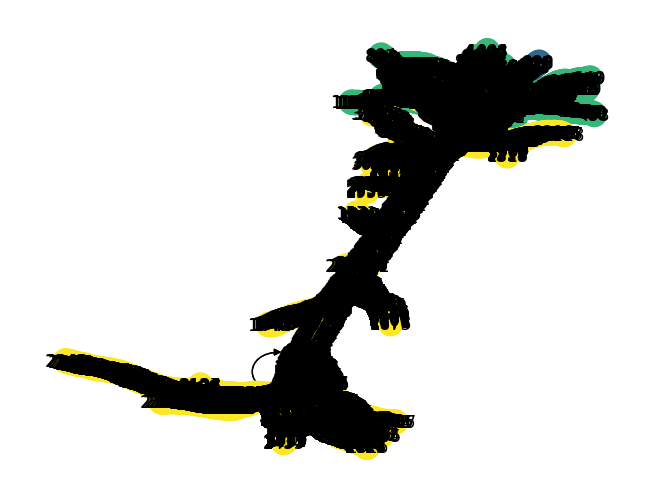

In [860]:
# Get node positions and colors
pos = {node: (jx_graph.nodes[node]['x'], jx_graph.nodes[node]['y']) for node in jx_graph.nodes()}

# Plot 1: Node indices
node_colors = [jx_graph.nodes[node]['id'] for node in jx_graph.nodes()]
nx.draw(jx_graph, pos=pos, node_color=node_colors, cmap='viridis', with_labels=True)

In [856]:
jx_branch_nodes, morph_branch_nodes

([array([0., 1.]), array([1., 2., 3.]), array([1., 4., 5., 6.])],
 [array([1, 2, 3]), array([1]), array([1, 4, 5, 6])])

In [861]:
morph_eq_jx = []

for i, b in enumerate(jx_branch_nodes):
    for j, mb in enumerate(morph_branch_nodes):
        if len(b) == len(mb):
            if np.allclose(b, mb):
                morph_eq_jx.append((i,j))
                break
if len(morph_eq_jx) > 0:
    diff_morph_branches = [b for i, b in enumerate(morph_branch_nodes) if i not in np.array(morph_eq_jx)[:,1]]
    diff_jx_branches = [b for j, b in enumerate(jx_branch_nodes) if j not in np.array(morph_eq_jx)[:,0]]
else:
    print("No branches are equal")
    diff_morph_branches = morph_branch_nodes
    diff_jx_branches = jx_branch_nodes

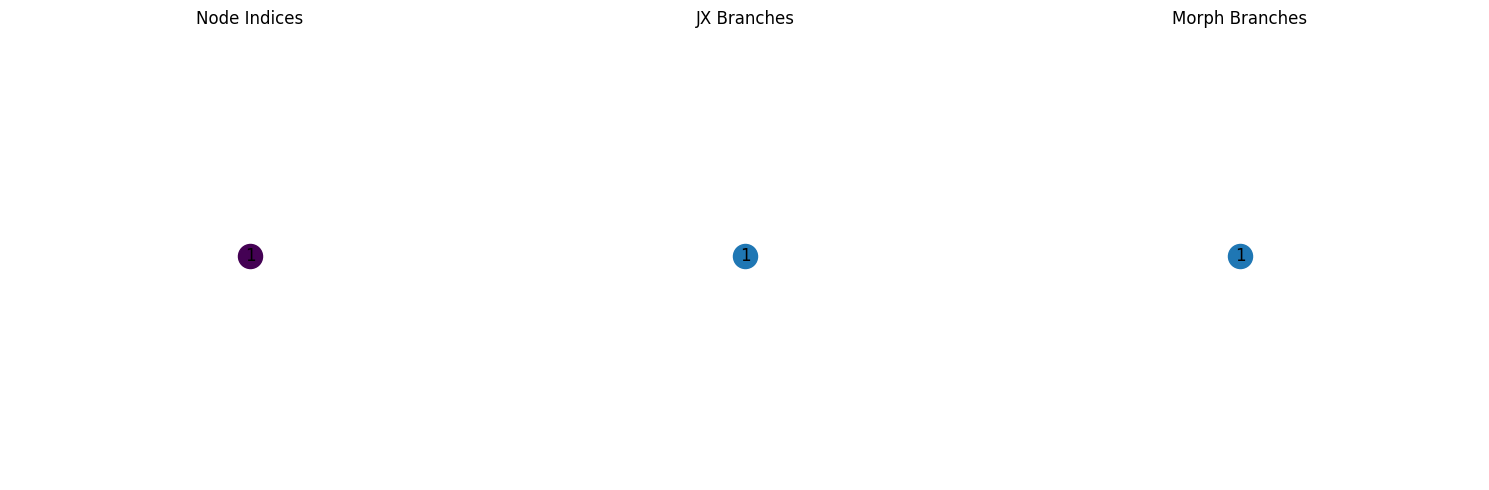

In [862]:
jx_subgraph = jx_graph.subgraph(np.unique(np.hstack(diff_morph_branches)))

# Get node positions and colors
pos = {node: (jx_subgraph.nodes[node]['x'], jx_subgraph.nodes[node]['y']) for node in jx_subgraph.nodes()}

# Create figure with 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Node indices
node_colors = [jx_subgraph.nodes[node]['id'] for node in jx_subgraph.nodes()]
nx.draw(jx_subgraph, pos=pos, node_color=node_colors, cmap='viridis', with_labels=True, ax=axes[0])
axes[0].set_title('Node Indices')

# Plot 2: JX branches
node_colors = np.zeros(len(jx_subgraph.nodes()))
for i, branch in enumerate(diff_jx_branches):
    node_colors[np.isin(list(jx_subgraph.nodes()), branch)] = i + 1
nx.draw(jx_subgraph, pos=pos, node_color=node_colors, cmap='tab10', with_labels=True, ax=axes[1])
axes[1].set_title('JX Branches')

# Plot 3: Morph branches
node_colors = np.zeros(len(jx_subgraph.nodes()))
for i, branch in enumerate(diff_morph_branches):
    node_colors[np.isin(list(jx_subgraph.nodes()), branch)] = i + 1
nx.draw(jx_subgraph, pos=pos, node_color=node_colors, cmap='tab10', with_labels=True, ax=axes[2])
axes[2].set_title('Morph Branches')

plt.tight_layout()
plt.show()

In [661]:
print("Morph branches:")
for b in diff_morph_branches:
    print([jx_graph.nodes[n]["id"] for n in b])
print()
print("JX branches:")
for b in diff_jx_branches:
    print([jx_graph.nodes[n]["id"] for n in b])


Morph branches:

JX branches:


In [52]:
# for i, b in enumerate(morph_branch_nodes):
#     pos = [(morph_graph.nodes[n]["x"], morph_graph.nodes[n]["y"]) for n in b]
#     plt.plot(*zip(*pos))

# for i, b in enumerate(jx_branch_nodes):
#     pos = [(jx_graph.nodes[n]["x"], jx_graph.nodes[n]["y"]) for n in b]
#     plt.plot(*zip(*pos))
# plt.show()
        
        

In [56]:
for jx_l, morph_l in zip(sorted(jx_branch_lens), sorted(morph_branch_lens)):
    print(jx_l, morph_l)

2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
3 2
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
4 3
4 4
4 4
4 4
4 4
4 4
4 4
4 5
5 5
5 5
5 5
5 5
5 5
5 5
6 6
6 6
6 6
6 6
6 6
6 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7
8 8
8 8
8 8
9 9
9 9
9 9
9 9
9 9
9 9
9 10
10 10
10 10
10 10
10 11
11 11
11 11
11 11
11 11
11 12
12 12
12 12
12 12
12 12
12 12
12 13
13 13
13 14
14 14
14 14
14 14
14 14
14 14
14 14
14 14
14 15
15 15
15 15
15 15
15 15
15 15
15 16
16 16
16 17
17 17
17 18
18 18
18 18
18 20
20 20
20 20
20 20
20 20
20 21
21 21
21 22
22 22
22 22
22 23
23 23
23 23
23 23
23 24
24 24
24 24
24 25
25 25
25 25
25 26
26 26
26 27
26 27
27 27
27 28
27 28
28 29
28 30
29 30
30 31
30 32
31 33
32 33
33 34
33 36
36 36
36 38
38 40
40 41
41 41
41 47
47 47
47 51
51 51
51 52
52 53
53 56
56 56
56 56
56 57
57 62
62 65
65 67
67 139


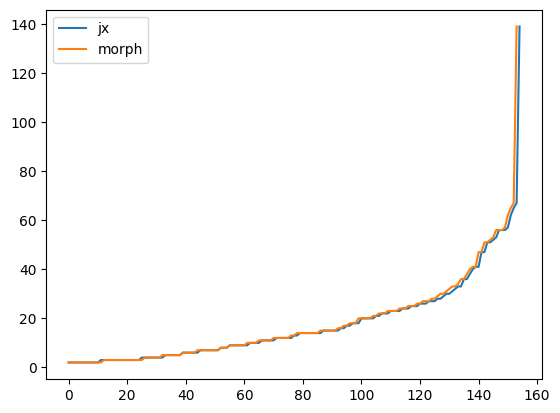

In [53]:
plt.plot(np.sort(jx_branch_lens), label="jx")
plt.plot(np.sort(morph_branch_lens), label="morph")
plt.legend()
plt.show()

In [4]:
def infer_module_type_from_inds(idxs: pd.DataFrame) -> str:
    nuniques = idxs[["cell_index", "branch_index", "comp_index"]].nunique()
    nuniques.index = ["cell", "branch", "compartment"]
    nuniques = pd.concat([pd.Series({"network": 1}), nuniques])
    return_type = nuniques.loc[nuniques == 1].index[-1]
    return return_type


def build_module_scaffold(
    idxs: pd.DataFrame,
    return_type: Optional[str] = None,
    parent_branches: Optional[List[np.ndarray]] = None,
) -> Union[jx.Network, jx.Cell, jx.Branch, jx.Compartment]:
    """Builds a skeleton module from a DataFrame of indices.
    This is useful for instantiating a module that can be filled with data later.
    Args:
        idxs: DataFrame containing cell_index, branch_index, comp_index, i.e.
            Module.nodes or View.view.
        return_type: Type of module to return. If None, the type is inferred from the
            number of unique values in the indices. I.e. only 1 unique cell_index
                and 1 unique branch_index -> return_type = "jx.Branch".
    Returns:
        A skeleton module with the correct number of compartments, branches, cells, or
        networks."""
    return_types = ["compartment", "branch", "cell", "network"]
    build_cache = {k: [] for k in return_types}

    if return_type is None:  # infer return type from idxs
        return_type = infer_module_type_from_inds(idxs)

    comp = jx.Compartment()
    build_cache["compartment"] = [comp]

    if return_type in return_types[1:]:
        nsegs = idxs["branch_index"].value_counts().iloc[0]
        branch = jx.Branch([comp for _ in range(nsegs)])
        build_cache["branch"] = [branch]

    if return_type in return_types[2:]:
        for cell_id, cell_groups in idxs.groupby("cell_index"):
            num_branches = cell_groups["branch_index"].nunique()
            default_parents = np.arange(num_branches) - 1  # ignores morphology
            parents = (
                default_parents if parent_branches is None else parent_branches[cell_id]
            )
            cell = jx.Cell([branch] * num_branches, parents)
            build_cache["cell"].append(cell)

    if return_type in return_types[3:]:
        build_cache["network"] = [jx.Network(build_cache["cell"])]

    module = build_cache[return_type][0]
    build_cache.clear()
    return module

In [5]:
def convert_view_to_module(view: View, reset_index: bool = True) -> "Module":
    """Extract part of a module and return a copy of its View or a new module.

    This can be used to call `jx.integrate` on part of a Module.

    Args:
        reset_index: if True, the indices of the new module are reset to start from 0.
        as_module: if True, a new module is returned instead of a View.

    Returns:
        A part of the module or a copied view of it."""
    view = deepcopy(view)
    if reset_index:
        view.nodes.reset_index(drop=True, inplace=True)
        view.edges.reset_index(drop=True, inplace=True)
        # TODO: also re-enumerate cell,branch,comp indices in nodes and edges

    testnodes = view.nodes.copy()
    testnodes.rename({"global_"+k:k for k in ["cell_index", "branch_index", "comp_index"]}, axis=1, inplace=True)
    mod_type = infer_module_type_from_inds(testnodes)
    module = build_module_scaffold(testnodes, mod_type)
    module.__dict__.update(view.__dict__)
    return module

In [6]:
branch = jx.Branch(ncomp=2)
branch[0].insert(HH())
branch.record()

comp = branch[0]
comp = convert_view_to_module(comp)
jx.integrate(comp, t_max=1)

Added 2 recordings. See `.recordings` for details.


Array([[-70.        , -69.48756081, -69.09088174, -68.77443768,
        -68.51477492, -68.29603413, -68.10727942, -67.94084395,
        -67.79127429, -67.65464046, -67.52807603, -67.40946647,
        -67.29723486, -67.19019277, -67.0874353 , -66.98826644,
        -66.89214546, -66.7986481 , -66.70743824, -66.61824695,
        -66.53085703, -66.44509138, -66.36080422, -66.27787448,
        -66.19620072, -66.11569714, -66.03629063, -65.9579183 ,
        -65.8805257 , -65.80406526, -65.72849517, -65.6537784 ,
        -65.57988194, -65.50677619, -65.43443445, -65.3628325 ,
        -65.29194826, -65.22176147, -65.15225352, -65.08340718,
        -65.01520646]], dtype=float64)

- change param / state naming convenetion for channels and synapses
- ensure that channel/synapse currents are prefixed on the module side
- ensure that args and kwargs in channels functions are same order and standardized (enforce this with tests)
- make channel / synapse name user facing ?
- jx.integrate(net1, t_max=0) runs one step
- are we testing inner vs outer loop of setting states / params in init_states / _step_channel_currents etc?
- add test to see if indices are handled correctly for two different mechs changing the same state at non-overlapping indices
- fix: 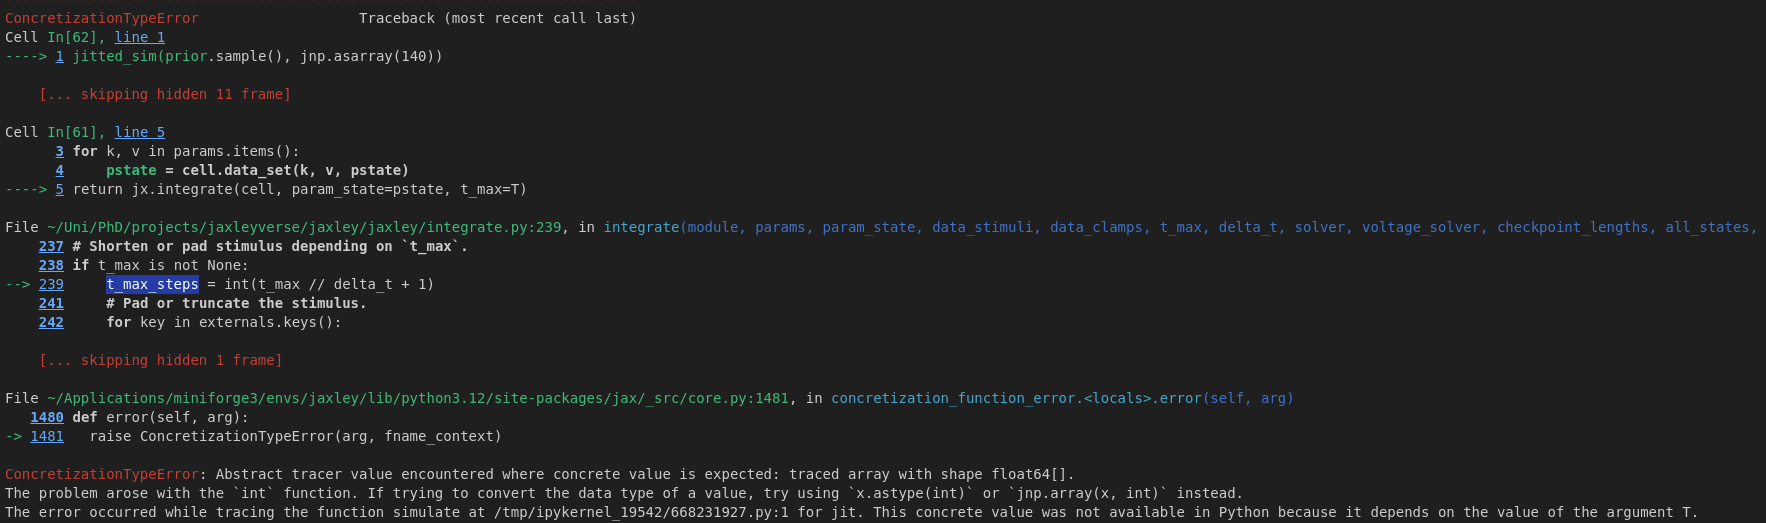
- add prepare_mechansim function (assert name does not exist already, assert conform to build rules)
- warn if states / params does not contain all global params
update_states vs. init_state
try:
    channel.update_states()
    channel.compute_current()
    channel.init_states()
except KeyError:
    warn("Some global param / state seems to be misssing")


- in the new channel API, `_filter_params_states` would have to filter potentially all channels, even the ones not in the channel. Better Solution! only filter global states!
- add current_name to synapses
- store global parameters in jaxnodes only once! i.e. for any global param jaxnodes["global_param_name"].shape == (1,) and duplicate if it is used multiple times
- should compute_current get dt arg?

In [25]:
def get_params_all_trainable(net):
    net.cell("all").branch("all").loc("all").make_trainable("HH_gNa")
    params = net.get_parameters()
    params[0]["HH_gNa"] = params[0]["HH_gNa"].at[:].set(0.0)
    net.to_jax()
    pstate = params_to_pstate(params, net.indices_set_by_trainables)
    print(pstate)
    return net.get_all_parameters(pstate, voltage_solver="jaxley.thomas")

def get_params_set(net):
    net.set("HH_gNa", 0.0)
    params = net.get_parameters()
    net.to_jax()
    pstate = params_to_pstate(params, net.indices_set_by_trainables)
    return net.get_all_parameters(pstate, voltage_solver="jaxley.thomas")

def SimpleComp():
    comp = jx.Compartment()
    return comp

def SimpleBranch(ncomp):
    comp = jx.Compartment()
    branch = jx.Branch([comp]*ncomp)
    return branch

def SimpleCell(nbranch, ncomp):
    branch = SimpleBranch(ncomp)
    cell = jx.Cell([branch]*nbranch, parents=[-1, 0, 0, 1, 1, 2, 2, 3, 3][:nbranch])
    return cell

def SimpleNet(ncell, nbranch, ncomp):
    cell = SimpleCell(nbranch, ncomp)
    net = jx.Network([cell]*ncell)
    return net

Number of newly added trainable parameters: 3. Total number of trainable parameters: 3


Array([[ 1,  2, -1],
       [ 6,  7, -1],
       [ 3, -1, -1]], dtype=int64)

In [ ]:
# global_params = ["v", "radius", "length", "axial_resistivity", "capacitance"]
# jaxnodes = {"global": {param: jnp.asarray(cell.nodes[param]) for param in global_params}}

# # Add channel-specific nodes and update globals
# for channel in cell.channels:
#     channel_dict = {}
#     for param, value in {**channel.states, **channel.params}.items():
#         if f"{channel._name}_" in param:
#             channel_dict[param] = jnp.asarray(cell.nodes[param][channel.indices])
#         else:
#             jaxnodes["global"][param] = jnp.asarray(cell.nodes[param])
#     jaxnodes[channel._name] = channel_dict

# # Update channel states
# for channel in cell.channels:
#     # Combine channel-specific and global nodes
#     channel_nodes = jaxnodes[channel._name].copy()
#     channel_nodes.update({k: v[channel.indices] for k, v in jaxnodes["global"].items()})
    
#     # Update states
#     channel_states_updated = channel.update_states(
#         channel_nodes, 0.025, channel_nodes["v"], channel_nodes
#     )
    
#     # Apply updates back to jaxnodes
#     for key, val in channel_states_updated.items():
#         mech_key = "global" if key in jaxnodes["global"] else channel._name
#         jaxnodes[mech_key][key] = jaxnodes[mech_key][key].at[channel.indices].set(val)

# def _iter_states_params(self, params=False, states=False) -> Tuple[str, jnp.ndarray]:
#     # TODO FROM #447: MAKE THIS WORK FOR VIEW?

#     # assert that either params or states is True
#     assert params or states, "Either params or states must be True."
#     global_states = ["v"]
#     morph_params = ["radius", "length", "axial_resistivity", "capacitance"]

#     for key in global_states + morph_params:
#         yield "global", key, self._inds_of_state_param[key]
            
#     mechs = self.channels + self.synapses
#     for mech in mechs:
#         data = self.nodes if isinstance(mech, Channel) else self.edges
#         params_states = mech.params if params else []
#         params_states += mech.states if states else []
#         for key in params_states:
#             if f"{mech._name}_" not in key:
#                 yield "global", key, jnp.asarray(data.index)
#             else:
#                 yield mech._name, key, mech.indices

# def _get_all_states_params(
#     self,
#     pstate: List[Dict],
#     voltage_solver=None,
#     delta_t=None,
#     all_params=None,
#     params=False,
#     states=False,
# ) -> Dict[str, jnp.ndarray]:
#     states_params = {}
#     pkeys = {k:[] for k in pstate}
#     for i, p in enumerate(pstate):
#         pkeys[p["key"]] += [i]

#     for mech_key, key, _ in self._iter_states_params(params, states):
#         jax_arrays = self.jaxnodes if key in self.nodes.columns else self.jaxedges
#         states_params[mech_key][key] = jax_arrays[mech_key][key]

#         if key in pkeys:
#             for i in pkeys[key]:
#                 # `inds` is of shape `(num_params, num_comps_per_param)`.
#                 # `set_param` is of shape `(num_params,)`
#                 # We need to unsqueeze `set_param` to make it `(num_params, 1)`
#                 #  for the `.set()` to work. This is done with `[:, None]`.
#                 inds, set_param = pstate[i]["indices"], pstate[i]["val"]
#                 states_params[mech_key][key] = states_params[key].at[inds].set(set_param[:, None])

#     if params:
#         # Compute conductance params and add them to the params dictionary.
#         states_params["axial_conductances"] = self._compute_axial_conductances(
#             params=states_params
#         )

#     if states:
#         all_params = states_params if all_params is None and params else all_params
#         for current in self.membrane_current_names:
#             states_params[current] = jnp.zeros_like(states_params['v'])
#         # Add to the states the initial current through every channel.
#         states, _ = self._channel_currents(
#             states_params, delta_t, self.channels, self.nodes, all_params
#         )

#         # Add to the states the initial current through every synapse.
#         states, _ = self._synapse_currents(
#             states_params, self.synapses, all_params, delta_t, self.edges
#         )
#     return states_params
    